# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [ ]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [ ]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [ ]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [ ]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [ ]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

## Import necessacry tools

In [1]:
from unityagents import UnityEnvironment
import matplotlib.pyplot as plt

import numpy as np
import random
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from collections import namedtuple, deque
import time
from datetime import datetime

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device: ", device)

device:  cuda:0


## Hyperparameters and Constants

In [2]:
BUFFER_SIZE = int(1e6)    # replay buffer size
BATCH_SIZE = 256          # minibatch size
RANDOM_SEED = 2           # ramdom seed
GAMMA = 0.99              # discount factor
TAU = 1e-2                # for soft update of target parameters
LR_ACTOR = 1e-3           # learning rate of the actor 
LR_CRITIC = 1e-3          # learning rate of the critic
WEIGHT_DECAY = 0          # L2 weight decay
#NUM_AGENTS = 2            # Number of agents
LEARN_EVERY = 2          # Learn every x time steps
LEARN_UPDATES = 4         # Number of learning steps

A_FC1_UNITS = 256         # Actor: Number of nodes in first hidden layer
A_FC2_UNITS = 128         # Actor: Number of nodes in second hidden layer
C_FCS1_UNITS = 256        # Critic: Number of nodes in first hidden layer
C_FC2_UNITS = 128         # Critic: Number of nodes in second hidden layer

ADD_NOISE = True          # Add noise to action 
OUNOISE_Theta = 0.15      # Theata for Ornstein-Uhlenbeck process
OUNOISE_SIGMA = 0.2       # Sigma for Ornstein-Uhlenbeck process
OUNOISE_MU = 0.           # Mue for Ornstein-Uhlenbeck process
NOISE_AMP = 2             # amplitude of OU noise
NOISE_DEC = 0.9999          # reduction rate for noise

N_EPISODES = 500         # Number of episodes
MAX_T = 5000              # Max length of one episode

BATCH_NORMAL = False       # Enable batch normalization

PRIO_REPLAY_DDPG = False  # Use priotized experience replay
MIN_P = 0.001             # small e for prioritized exp replay
ALPHA_ = 0.57             # how much prioritization is used (0 - no prioritization, 1 - full prioritization)
BETA_START = 0.0001       # importance sampling weight - degree for use (0 - no correction, 1 - full correction)
BETA_DELTA = 0.0004       # importance sampling weight

## Model

In [3]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=A_FC1_UNITS, fc2_units=A_FC2_UNITS):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.batch_norm_a = nn.BatchNorm1d(fc1_units)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        if BATCH_NORMAL:
            x = self.batch_norm_a(F.relu(self.fc1(state)))
        else:
            x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return F.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=C_FCS1_UNITS, fc2_units=C_FC2_UNITS):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.batch_norm_c1 = nn.BatchNorm1d(fcs1_units)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.batch_norm_c2 = nn.BatchNorm1d(fc2_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        if BATCH_NORMAL:
            xs = self.batch_norm_c1(F.leaky_relu(self.fcs1(state)))
        else:
            xs = F.leaky_relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.leaky_relu(self.fc2(x))        
        return self.fc3(x)

## Agents

In [4]:
class DDPG_Agent():
    
    buffer_memory = None
    agent_critic_local = None
    agent_critic_target = None
    agent_critic_optimizer = None
    agent_instances = []    
    
    """Interacts with and learns from the environment."""
    def __init__(self, state_size, action_size, random_seed):
        """Initialize an Agent object.
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Initialize Critic Network
 
        # Initilise Class levell Critic Network
        if DDPG_Agent.agent_critic_local is None:
            DDPG_Agent.agent_critic_local = Critic(state_size, action_size, random_seed).to(device)
        if DDPG_Agent.agent_critic_target is None:
            DDPG_Agent.agent_critic_target = Critic(state_size, action_size, random_seed).to(device)
        if DDPG_Agent.agent_critic_optimizer is None:
            DDPG_Agent.agent_critic_optimizer = optim.Adam(DDPG_Agent.agent_critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)
        # Critic Network (w/ Target Network)
        self.critic_local = DDPG_Agent.agent_critic_local
        self.critic_target = DDPG_Agent.agent_critic_target
        self.critic_optimizer = DDPG_Agent.agent_critic_optimizer
        
        '''
        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)        
        '''

        # Noise process
        #self.noise = OUNoise((num_agents,action_size), random_seed)
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        ##self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
        
        # Replay memory
        
        if DDPG_Agent.buffer_memory is None:
            if PRIO_REPLAY_DDPG:
                DDPG_Agent.buffer_memory  = Prio_ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed, MIN_P, ALPHA_, BETA_START, BETA_DELTA)
            else:
                DDPG_Agent.buffer_memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
   
        '''
        if PRIO_REPLAY_DDPG:
            self.memory = Prio_ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed, MIN_P, ALPHA_, BETA_START, BETA_DELTA)
        else:
            self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
         '''
        # Add this instances - we need to access all agent states whilst learning
        self.agent_nb=len(DDPG_Agent.agent_instances)
        DDPG_Agent.agent_instances.append(self)
        print("Appended to DDPG_Agent.agent_instances agent No. {}".format(self.agent_nb))

    def step(self, states, actions, rewards, next_states, dones, t):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        #for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
        #    DDPG_Agent.buffer_memory.add(state, action, reward, next_state, done)
        DDPG_Agent.buffer_memory.add(states, actions, rewards, next_states, dones)

        # Learn, if enough samples are available in memory
        if len(DDPG_Agent.buffer_memory) > BATCH_SIZE and t % LEARN_EVERY == 0:
            for i in range(LEARN_UPDATES):
                experiences = DDPG_Agent.buffer_memory.sample()
                self.learn(experiences, GAMMA)
    ''' 
    def act(self, state, add_noise=True, eps_noise=0.0):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()

        if add_noise:
            action += self.noise.sample() * eps_noise
        return np.clip(action, -1, 1)
    '''
    def act(self, state, add_noise=False, noise_amplitude=0.0):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample() * noise_amplitude
        return np.clip(action, -1, 1)
   

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        #states, actions, rewards, next_states, dones = experiences

        if PRIO_REPLAY_DDPG:
            states, actions, rewards, next_states, dones, tupel_probs, prio_probs_idx, max_prob = experiences
        else:
            states, actions, rewards, next_states, dones = experiences 
            

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        #critic_loss = F.mse_loss(Q_expected, Q_targets)       
        
        if PRIO_REPLAY_DDPG:
            # calculate TD error
            TD_error = (Q_targets - Q_expected)
            new_TD_deltas = torch.abs(TD_error.detach().squeeze(1)).cpu().numpy()
            # update priority for each tupel
            self.memory.update_TD_deltas(prio_probs_idx, np.abs(new_TD_deltas))
            # calculate loss function
            beta_ = self.memory.new_beta()
            TD_loss = TD_error**2
            importance_samp_weights = (len(self.memory) * tupel_probs)**(-beta_)
            # normalize weights
            
            max_weight = (len(self.memory) * max_prob)**(-beta_)
            importance_samp_weights /= max_weight
            critic_loss = torch.mean(TD_loss * importance_samp_weights)
        else:
            # calculate loss function
            critic_loss = F.mse_loss(Q_expected, Q_targets)       
        
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)

        
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)


class OUNoise:
    """Ornstein-Uhlenbeck process"""
    def __init__(self, size, seed, mu=OUNOISE_MU, theta=OUNOISE_Theta, sigma=OUNOISE_SIGMA, scale=0.1):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.size = size
        self.seed = random.seed(seed)
        self.scale = scale
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state * self.scale


class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""
    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(
          device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)
    
class Prio_ReplayBuffer:
    """Fixed-size buffer to store experience tuples with prioitized exp replay."""
    def __init__(self, action_size, buffer_size, batch_size, seed, min_p=1e-5, alpha = 0.6, beta = 0.001, delta_beta = 0.0005):
        """Initialize a ReplayBuffer object.

        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
            min_p(float): small constant value e to prevent tuples from starving
        """    
        self.memory = deque(maxlen=buffer_size)
        self.TD_deltas = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.min_p = min_p
        self.alpha = alpha
        self.beta = beta
        self.delta_beta = delta_beta
                
        self.experience = namedtuple("Experience", field_names=["state","action","reward","new_state","done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, int(done))
        self.memory.append(e)
        # use the max priority possible for initialization for getting a better chance for beeing selected in the next learning steps
        self.TD_deltas.append(max(self.TD_deltas) if len(self.TD_deltas) > 0 else self.min_p) 
        
        
    
    def sample(self):
        TD_deltas = np.array(self.TD_deltas)
        # create probability distribution equal to tupels priority value PI, normalize by the sum of all priority values in the replay buffer
        TD_probs = TD_deltas**self.alpha / np.sum(TD_deltas**self.alpha)
        # create a index_batch with this probabilties
        prio_probs_idx = np.random.choice(np.arange(len(self.memory)), size=self.batch_size, p=TD_probs, replace=False)
        # select all tupels with these indices
        states = torch.from_numpy(np.vstack([self.memory[k].state for k in prio_probs_idx])).float().to(device)
        actions = torch.from_numpy(np.vstack([self.memory[k].action for k in prio_probs_idx])).float().to(device)  
        rewards = torch.from_numpy(np.vstack([self.memory[k].reward for k in prio_probs_idx])).float().to(device)
        new_states = torch.from_numpy(np.vstack([self.memory[k].new_state for k in prio_probs_idx])).float().to(device)
        dones = torch.from_numpy(np.vstack([self.memory[k].done for k in prio_probs_idx]).astype(np.uint8)).float().to(
          device)
        
        max_prob = np.amax(TD_probs)
        tupel_probs = torch.from_numpy(np.vstack([TD_probs[k] for k in prio_probs_idx])).float().to(device)
        #print(actions)
        #print(tupel_probs)
        return states, actions, rewards, new_states, dones, tupel_probs, prio_probs_idx, max_prob
    
    def update_TD_deltas(self,prio_probs_idx, new_TD_deltas):
        for i,k in enumerate(prio_probs_idx):
            self.TD_deltas[k] = new_TD_deltas[i] + self.min_p

    def new_beta(self):
        self.beta+=self.delta_beta
        return min(self.beta, 1)
    
    def __len__(self):
        return len(self.memory)

## Training

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]
Appended to DDPG_Agent.agent_instances agent No. 2
Appended to DDPG_Agent.agent_instances agent No. 3
Episode:50, Best Score:0.10, Average Score:0.01, Best Avg Score:0.06
Episode 50	Average Score: 0.01	Best Average Score: 0.06
Episode:100, Best Score:0.10, Average Score:0.01, Best Avg Score:0.06
Episode 100	Average Score: 0.01	Best Average Score: 0.06
Episode:150, Best Score:2.60, Average Score:0.18, Best Avg Score:0.18
Episode 150	Average Score: 0.18	Best Average Score: 0.18

Environment solved in 72 episodes!	Average Score: 0.51
Saving scores data to:
201903132156_solved_72__nb_

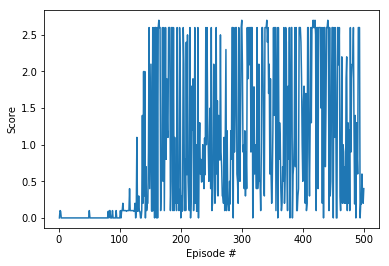


 [HYPERPARAMETER]training ddpg agent with following parameters: 
 state_size=		24
 action_size=		2
 random_seed=		2 
 number_agents=		2 
 max_t=			5000 
 actor_fc1_units=	256 
 actor_fc2_units=	128
 critic_fcs1_units=	256 
 critic_fc2_units=	128
 buffer_size=		1000000 
 batch_size=		256
 gamma=			0.99 
 tau=			0.01 
 lr_actor=		0.001 
 lr_critic=		0.001 
 weight_decay=		0
 mu=			0.0 
 theta=			0.15  
 sigma=			0.2 
 batch_normalization=	False 
 Prio_exp_Buffer=	False



In [7]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

####################################################################

"""
DDPG - Deep Deterministic Policy Gradients
input   - n_episodes = max number of training epsiodes
        - max_t = max timesteps for one episode
"""

def ddpg(n_episodes=3500, max_t=1000):
    scores_max = deque(maxlen=100)  # last 100 scores
    scores = []
    scores_eps = []
    file_name = 'without_result'
    best_score = 0
    best_average_score = 0
    agents = []
    target = 0.5
    
    eps_noise = NOISE_AMP
    
    for i in range(num_agents):
        agents.append(DDPG_Agent(state_size=state_size, action_size=action_size, random_seed=RANDOM_SEED))
    
    for i_episode in range(1, n_episodes + 1):
        env_info = env.reset(train_mode=True)[brain_name]    # reset the environment
        states = env_info.vector_observations                 # get the initial state
        for agent in agents:
            agent.reset()
            
        scores_agents = np.zeros(num_agents)
        
        for t in range(max_t):
            # select an action (for each agent)
            actions = np.array([agents[i].act(states[i], ADD_NOISE, eps_noise) for i in range(num_agents)])
            #actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
            #actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
            
            eps_noise *= NOISE_DEC
            #actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
            env_info = env.step(actions)[brain_name]         # send all actions to the environment
            next_states = env_info.vector_observations        # get the next state (for each agent)
            rewards = env_info.rewards                        # get the reward (for each agent)
            dones = env_info.local_done                       # see if episode has finished
            
            for i in range(num_agents):
                agents[i].step(states[i], actions[i], rewards[i], next_states[i], dones[i], t) 
                
            states = next_states                                    # roll over states to next time step
            scores_agents += rewards                                   # update the score (for each agent)
            if np.any(dones):                                         # exit loop if episode finished
                break
                
                
        score = np.max(scores_agents)
        scores_max.append(score)
        average_score = np.mean(scores_max)
        scores.append(score)
        if score > best_score:
            best_score = score
        if average_score > best_average_score:
            best_average_score = average_score
        '''
        print(
            "Episode:{}, Low Score:{:.2f}, High Score:{:.2f}, Average Score:{:.2f}, Best Avg Score:{:.2f}".format(
            i_episode, scores_agents.min(), scores_agents.max(), average_score, best_average_score))
        '''
               
        if average_score >= target:
            solved_in = i_episode - 100
            print(
            '\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(solved_in, average_score))
            timestamp = datetime.strftime(datetime.now(), "%Y%m%d%H%M")
            file_name = """{}_solved_{}__nb_agents_{}__maxt_{}__A_FC1_{}__A_FC2_{}__C_FC1_{}__C_FC2_{}__buffer_{}"""\
                        """__batch_{}__gamma_{}__tau_{}__lr_a_{}__lr_c_{}__weight_d{}__b_norm_{}__prio_b_{}""".\
                        format(timestamp, solved_in, num_agents, MAX_T, A_FC1_UNITS, A_FC2_UNITS, C_FCS1_UNITS,\
                          C_FC2_UNITS, BUFFER_SIZE, BATCH_SIZE, GAMMA, TAU, LR_ACTOR, LR_CRITIC, WEIGHT_DECAY, \
                          BATCH_NORMAL, PRIO_REPLAY_DDPG)

            for i in range(num_agents):
                fn_actor = './saved_models/' + file_name + '_check_actor' + str(i) + '.pth'
                fn_critic = './saved_models/' + file_name + '_check_critic' + str(i) + '.pth'
                print("Saving scores data to:\n{}".format(file_name))
                torch.save(agents[i].actor_local.state_dict(), fn_actor)
                torch.save(agents[i].critic_local.state_dict(), fn_critic)
          
            torch.save(agent.actor_local.state_dict(), fn_actor)
            torch.save(agent.critic_local.state_dict(), fn_critic)
            target +=0.5
            #break
        if i_episode % 50 == 0:
            for i in range(num_agents):
                torch.save(agents[i].actor_local.state_dict(), './saved_models/checkpoint_actor' + str(i) + '.pth')
                torch.save(agents[i].critic_local.state_dict(), './saved_models/checkpoint_critic' + str(i) + '.pth')
            print(
            "Episode:{}, Best Score:{:.2f}, Average Score:{:.2f}, Best Avg Score:{:.2f}".format(
            i_episode, best_score, average_score, best_average_score))
            print('\rEpisode {}\tAverage Score: {:.2f}\tBest Average Score: {:.2f}'.format(i_episode, average_score, best_average_score))
    results = []
    results.append(scores)
    results.append(file_name)
    return results #scores

start_time = time.time() # Monitor Training Time 
scores, file_name = ddpg(n_episodes=N_EPISODES, max_t=MAX_T)
env.close()

print("\nTotal Training time = {:.1f} min".format((time.time()-start_time)/60))
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores) + 1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
img_name = './images/' + file_name + '_train_performance.png'
plt.savefig(img_name)   # save the figure to file
plt.show()

print("""\n [HYPERPARAMETER]training ddpg agent with following parameters: \n state_size=\t\t{}\n action_size=\t\t{}"""\
      """\n random_seed=\t\t{} \n number_agents=\t\t{} \n max_t=\t\t\t{} \n actor_fc1_units=\t{} \n actor_fc2_units=\t{}"""\
      """\n critic_fcs1_units=\t{} \n critic_fc2_units=\t{}\n buffer_size=\t\t{} \n batch_size=\t\t{}"""\
      """\n gamma=\t\t\t{} \n tau=\t\t\t{} \n lr_actor=\t\t{} \n lr_critic=\t\t{} \n weight_decay=\t\t{}"""\
      """\n mu=\t\t\t{} \n theta=\t\t\t{}  \n sigma=\t\t\t{} \n batch_normalization=\t{} \n Prio_exp_Buffer=\t{}\n"""\
      .format(state_size, action_size, RANDOM_SEED, num_agents, MAX_T, A_FC1_UNITS, A_FC2_UNITS, C_FCS1_UNITS,\
              C_FC2_UNITS, BUFFER_SIZE, BATCH_SIZE, GAMMA, TAU, LR_ACTOR, LR_CRITIC, WEIGHT_DECAY, OUNOISE_MU,\
              OUNOISE_Theta,OUNOISE_SIGMA, BATCH_NORMAL, PRIO_REPLAY_DDPG))

In [6]:
env.close()

## Evaluation

In [ ]:
env = UnityEnvironment(file_name='../Reacher_Windows_x86_64/Reacher.exe')

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=False)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

agent = DDPG_Agent(state_size=state_size, action_size=action_size, random_seed=RANDOM_SEED)
for i in range(num_agents):
    agent[i].actor_local.load_state_dict(torch.load('checkpoint_actor' + str(i) + '.pth'))
    agent[i].critic_local.load_state_dict(torch.load('checkpoint_critic' + str(i) + '.pth'))

#env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
states = env_info.vector_observations                   # get the initial state
agent.reset()
while True: 
    actions = np.array([agents[i].act(states[i]) for i in range(num_agents)])
    #actions = agent.act(states)                         # select an action (for each agent)
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))
env.close()